In [20]:
# For EDA now, will add more libraries as we progress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

# Set nice style for plots
sns.set_theme(style='darkgrid')
sns.dark_palette("#69d", reverse=True, as_cmap=True)
sns.set_context("paper")



# 1. Read Data

Our data was taken from this database of [Google Maps Restaurant Reviews](https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/#subsets). We previously used a smaller dataset available [here](https://www.kaggle.com/datasets/denizbilginn/google-maps-restaurant-reviews), with only 1100 reviews, but as per our TF's recommendation, we will be using this larger dataset with over 10m reviews for Massachusetts alone. To speed up our EDA, we will be using a sample of 100,000 reviews.

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

Our main dataset, stored in the `df` variable, contains 100,000 reviews. Our columns of interest are `rating`, which is the rating given by the user, `text`, which is the review text, and `gmap_id`, which is the Google Maps ID of the restaurant. 

We also have a metadata dataset, stored in the `df_meta` variable, which contains information about each restaurant in Massachusetts. The columns of interest are `gmap_id`, allowing us to join this dataset with the main one, `name`, which is the name of the restaurant, and `description`, which is a brief description of the restaurant.

In [21]:
# Load first 100000 json objects from review-Massachusetts_10.json. These are the reviews themselves.

# Load the data
with open('data/review-Massachusetts_10.json', 'r') as f:
    data = f.readlines()

data_head = data[:100000]

# Convert to dataframe
data_json_str = "[" + ','.join(data_head) + "]"
df = pd.read_json(data_json_str)

# Also load the whole meta-Massachusetts.json file. This contains metadata about the businesses, since the reviews only contain the restaurant id.
with open('data/meta-Massachusetts.json', 'r') as f:
    data_meta = f.readlines()

data_meta_str = "[" + ','.join(data_meta) + "]"
df_meta = pd.read_json(data_meta_str)

/var/folders/d8/kwvs0tzd5t7dkrqj0r00cjzr0000gn/T/ipykernel_47933/2968537273.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(data_json_str)
/var/folders/d8/kwvs0tzd5t7dkrqj0r00cjzr0000gn/T/ipykernel_47933/2968537273.py:18: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_meta = pd.read_json(data_meta_str)


In [22]:
# Examine df
print(df.info())
print(df.head())

# Examine df_meta
print(df_meta.info())
print(df_meta.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  100000 non-null  float64
 1   name     100000 non-null  object 
 2   time     100000 non-null  int64  
 3   rating   100000 non-null  int64  
 4   text     55661 non-null   object 
 5   pics     2734 non-null    object 
 6   resp     11496 non-null   object 
 7   gmap_id  100000 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 6.1+ MB
None
        user_id              name           time  rating  \
0  1.180340e+20     Donna Carlson  1619732714443       5   
1  1.101673e+20   michael simmons  1615400031636       5   
2  1.122136e+20       Paul Murray  1593992657241       5   
3  1.081745e+20  Elba De Oliveira  1582074606394       5   
4  1.089901e+20      Sherri Mayne  1572962045881       5   

                                                text  pics  resp  \
0    

# 2. Simple EDA

## Exploring the distribution of ratings

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* Ratings are on a 1 to 5 scale.
* The majority of reviews are positive, with 67933 reviews rated 5 and 16619 reviews rated 4.
* Much fewer reviews have lower ratings - less than 10000 each for ratings 3, 2, and 1.

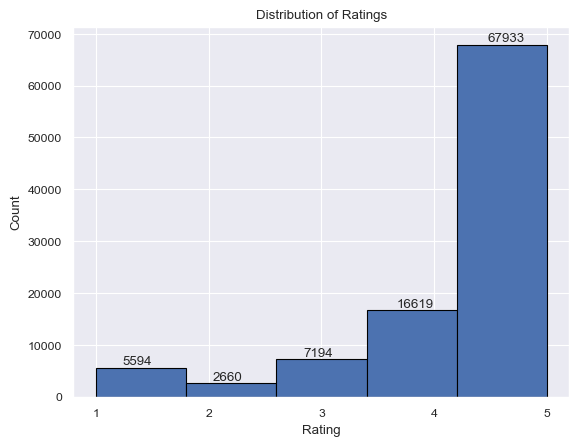

In [58]:
# Distribution of ratings: To understand the overall sentiment towards the businesses.

plt.hist(df['rating'], bins = 5, edgecolor = 'black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
# show exact counts
for i in range(1, 6):
    plt.text(i + 0.5 if i == 1 else i + 0.3 if i == 2 else i + 0.1 if i == 3 else i if i == 4 else i - 0.2, len(df[df['rating'] == i]), str(len(df[df['rating'] == i])), ha='right', va='bottom')
# change x ticks to read 1, 2, 3, 4, 5
plt.xticks(np.arange(1, 6, 1))

plt.show()


## Exploring review counts per restaurant

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* Most businesses have 10-20 reviews, with the number of businesses decreasing at a decreasing rate as the number of reviews increases.
* The mean number of reviews is 19.7 with a standard deviation of 14.5.
* This suggests that a small number of restaurants might be overrepresented in our dataset, especially the one outlying restaurant with 526 reviews.

Summary statistics for count of reviews per business:
count    5077.000000
mean       19.696671
std        14.529249
min        10.000000
25%        12.000000
50%        16.000000
75%        23.000000
max       526.000000
Name: count, dtype: float64


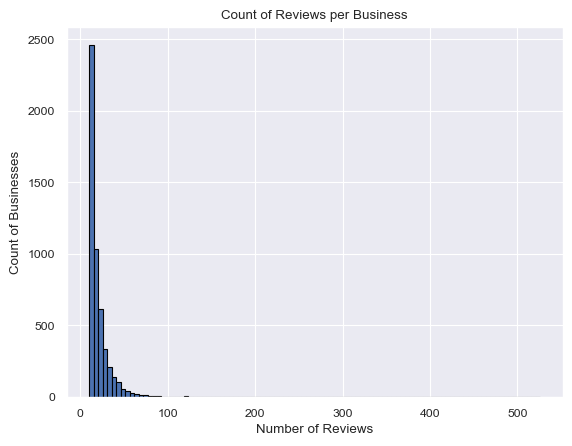

In [74]:
# Count of reviews per business - To see which businesses have been reviewed the most.

# describe the count of reviews per business
print("Summary statistics for count of reviews per business:")
print(df['gmap_id'].value_counts().describe())

df['gmap_id'].value_counts().plot(kind='hist', bins=100, edgecolor='black')
plt.title('Count of Reviews per Business')
plt.xlabel('Number of Reviews')
plt.ylabel('Count of Businesses')
plt.show()




## Exploring review lengths (in terms of number of characters)

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We see that review lengths are distributed similarly to restaurant ratings, with a large number of reviews having under 100 characters, and with the number of reviews decreasing at a decreasing rate as the review length increases.
* The mean review length is 80, but with a large standard deviation of 180.

Summary statistics for review length:
count    100000.00000
mean         80.19012
std         180.68605
min           0.00000
25%           0.00000
50%          17.00000
75%          85.00000
max        4092.00000
Name: review_length, dtype: float64


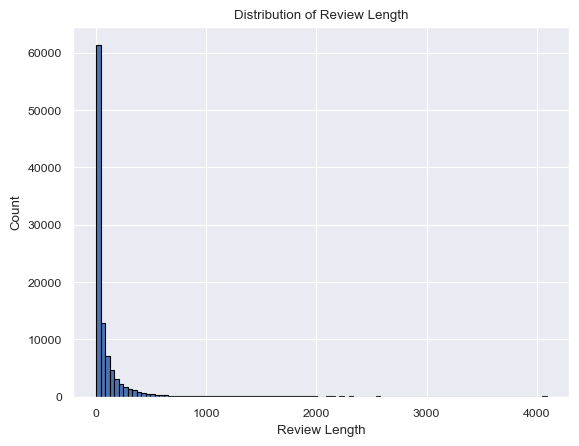

In [82]:
# Review length analysis: To see the distribution of the length of the review texts.

df['review_length'] = df['text'].apply(lambda x: len(x) if x is not None else 0)

# describe the review length
print("Summary statistics for review length:")
print(df['review_length'].describe())

plt.hist(df['review_length'], bins=100, edgecolor='black')
plt.title('Distribution of Review Length')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()



## Exploring correlation between review length and rating

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We analyzed the correlation between the length of the review text and the rating. The correlation coefficient is around -0.15, which suggests that there is only a weak negative correlation between the length of the review and the rating.
* This result is consistent with our intuition, as the length of a review does not necessarily indicate its quality or sentiment.
* However, perhaps some angrier customers might leave longer reviews, which could explain the slight negative correlation.

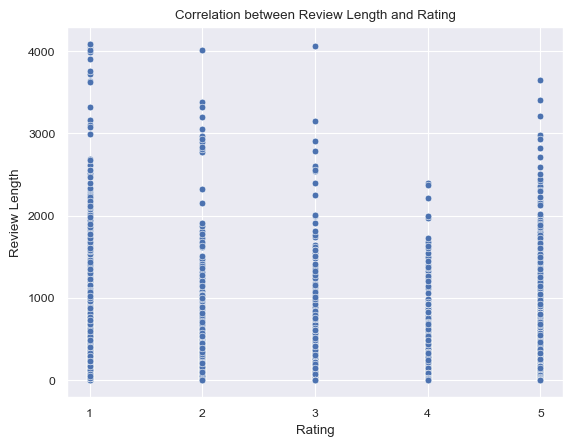

Correlation matrix:
                 rating  review_length
rating         1.000000      -0.155611
review_length -0.155611       1.000000


In [72]:
# Correlation between review length and rating: To see if there is a correlation between the length of the review and the rating given.

# plot the correlation between review length and rating
sns.scatterplot(x='rating', y='review_length', data=df)
plt.title('Correlation between Review Length and Rating')
plt.xlabel('Rating')
plt.ylabel('Review Length')
plt.xticks(np.arange(1, 6, 1))
plt.show()

correlation_matrix = df[['rating', 'review_length']].corr()
print("Correlation matrix:")
print(correlation_matrix)

## Number of unique authors

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We see that we have 61,461 unique authors for our 100,000 reviews, which suggests that most authors have only left one review.
* This is confirmed by the mean number of reviews per author, which is 1.6 with a standard deviation of 1.3.
* Almost all authors have left less than 10 reviews, except one outlier who left 75.
* The shape of the distribution is once again similar to the previous two, with the number of authors decreasing at a decreasing rate as the number of reviews per author increases.

Number of unique authors:  61461
Summary statistics for number of ratings per author:
count    61461.000000
mean         1.627048
std          1.306976
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         75.000000
Name: count, dtype: float64


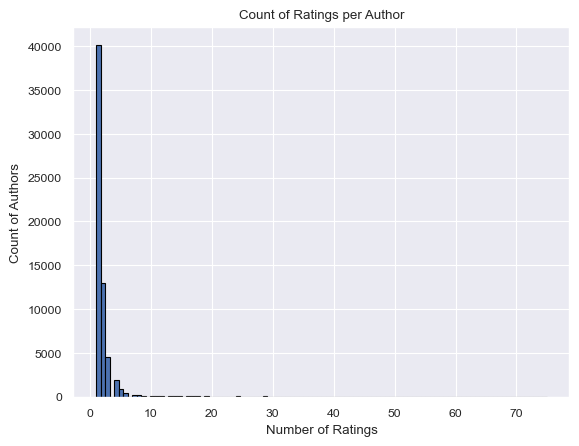

In [83]:
# How many unique authors?

print("Number of unique authors: ", df['name'].nunique())

# describe the count of ratings per author
print("Summary statistics for number of ratings per author:")
print(df['name'].value_counts().describe())

df['name'].value_counts().plot(kind='hist', bins=100, edgecolor='black')
plt.title('Count of Ratings per Author')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Authors')
plt.show()


## Simple sentiment analysis

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

* We used the `TextBlob` library to perform a simple sentiment analysis on the review text.
* First, we dropped reviews with no text, as they would not provide any information for sentiment analysis.
* We then calculated the polarity of each review, which ranges from -1 (most negative) to 1 (most positive).
* Plotting a histogram and summary statistics, we see that most reviews are moderately positive with a mean polarity of 0.40 and a standard deviation of 0.34. This is consistent with our earlier observation that most ratings are positive (4 or 5 stars).
* The distribution is roughly bell-shaped, but with a density spike at 0 and a few more spikes above 0.5. 

Summary statistics for sentiment:
count    55661.000000
mean         0.402722
std          0.336367
min         -1.000000
25%          0.187500
50%          0.404286
75%          0.642500
max          1.000000
Name: sentiment, dtype: float64


/var/folders/d8/kwvs0tzd5t7dkrqj0r00cjzr0000gn/T/ipykernel_47933/3980335880.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropped['sentiment'] = df_dropped['text'].apply(lambda x: TextBlob(x).sentiment.polarity)


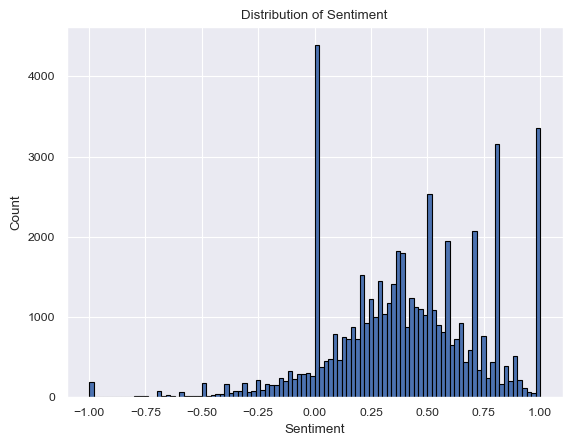

In [84]:
# Simple sentiment analysis on review text

# Add a column to the dataframe with the sentiment of the review
df_dropped = df.dropna(subset=['text'])
df_dropped['sentiment'] = df_dropped['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# print summary statistics
print("Summary statistics for sentiment:")
print(df_dropped['sentiment'].describe())

# plot the distribution of sentiment
plt.hist(df_dropped['sentiment'], bins=100, edgecolor='black')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

<div style="background-color:#3F7FBF; color:white; padding:10px"> 

There is a moderate positive correlation between sentiment score and rating, with a correlation coefficient of 0.51. This suggests that reviews with higher ratings tend to have more positive sentiment scores, which is expected.

In [85]:
# Find correlation between sentiment and rating
correlation_matrix = df_dropped[['rating', 'sentiment']].corr()
print("Correlation matrix:")
print(correlation_matrix)

Correlation matrix:
             rating  sentiment
rating     1.000000   0.513979
sentiment  0.513979   1.000000
